Need to clone lsst/throughputs and setenv THROUGHPUTS_DIR to point to that directory first.

In [8]:
import sncosmo
import analyzeSN as ans

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Comparison of model and simulated data
We already know how to extract the data from the simulations. The data is the model light curve + noise. The model used here is SALT2, which has a few parameters ['x0', 'x1', 'c', 'z', 't0']. We must estimate the values of these parameters from the data

In [2]:
simdata = ans.SNANASims.fromSNANAfileroot('LSST_Ia', location='ENIGMA_LSSTMAIN/', coerce_inds2int=False)
print simdata.headData.shape

(1622, 78)


Find SNe with large numbers of observations (for demonstration)

In [ ]:
nobs = [simdata.get_SNANA_photometry(snid=snid).lightCurve.shape[0] for snid in simdata.headData.index.values]

In [13]:
print np.array(nobs).max()
snid = simdata.headData.index.values[np.argmax(np.array(nobs))]
print snid

71
3942


In [14]:
#hd = simdata.headData.query('REDSHIFT_FINAL > 0.2 and REDSHIFT_FINAL < 0.25').head(5).copy()
hd = simdata.headData.query('NOBS > 50').head(5).copy()
#hd = simdata.headData.query('REDSHIFT_FINAL < 0.1').head(5).copy()
#snid = hd.index.values[2]
print snid
hd

3942


,IAUC,FAKE,RA,DECL,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y
SNID,,,,,,,,,,,,,,,,,,,,,
3942,NULL,2,0.000000,-0.794553,0.2,-9,-9,1,71,5757,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
14174,NULL,2,2.646689,-0.355408,0.2,-9,-9,1,51,20809,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [15]:
lcobj = simdata.get_SNANA_photometry(snid=snid)
print lcobj.lightCurve.shape
#lcobj.lightCurve

(71, 22)


In [16]:
print simdata.headData.ix[snid]
hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
from collections import OrderedDict as odict
hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                                    SIM_SALT2x0='x0',
                                                                                    SIM_SALT2x1='x1',
                                                                                    SIM_SALT2c='c',
                                                                                    SIM_MWEBV='ebv',                                   
                                                                                    REDSHIFT_FINAL='z')).apply(odict, axis=1)

IAUC                      NULL    
FAKE                             2
RA                               0
DECL                     -0.794553
PIXSIZE                        0.2
NXPIX                           -9
NYPIX                           -9
SNTYPE                           1
NOBS                            71
PTROBS_MIN                    5757
PTROBS_MAX                    5827
MWEBV                         0.01
MWEBV_ERR                   0.0016
REDSHIFT_HELIO            0.774001
REDSHIFT_HELIO_ERR          0.0005
REDSHIFT_FINAL            0.771876
REDSHIFT_FINAL_ERR          0.0005
HOSTGAL_OBJID                12333
HOSTGAL_PHOTOZ            0.764214
HOSTGAL_PHOTOZ_ERR           0.014
HOSTGAL_SPECZ                    0
HOSTGAL_SPECZ_ERR                0
HOSTGAL_SNSEP                 -999
HOSTGAL_LOGMASS                 -9
HOSTGAL_LOGMASS_ERR             -9
HOSTGAL_MAG_u                  999
HOSTGAL_MAG_g                  999
HOSTGAL_MAG_r                  999
HOSTGAL_MAG_i       

In [17]:
hd['params'].ix[snid]

OrderedDict([('t0', 52534.863),
             ('x0', 3.3000356e-06),
             ('x1', 0.7941221),
             ('c', 0.042838477),
             ('z', 0.77187568)])

In [18]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
model.set(**hd.ix[snid].params)

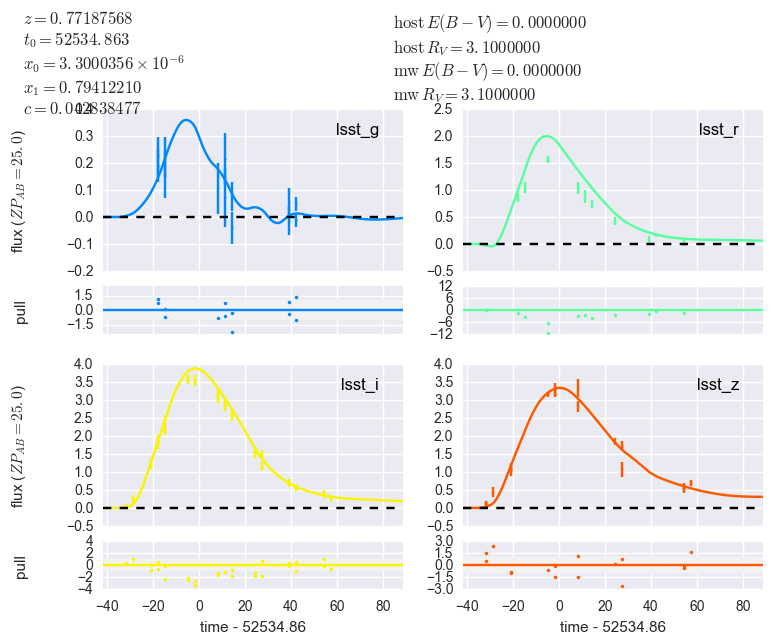

In [19]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)

### Inferring the model parameters from the data
First we will use a max likelihood method for estimating the model parameters

In [20]:
fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

In [21]:
print fitres[0].parameters
fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
fitresChar.parameters

[  7.71875679e-01   5.25347517e+04   3.04719059e-06   1.07819625e+00
   1.34875506e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]


z              0.771876
t0         52534.751701
x0             0.000003
x1             1.078196
c              0.134876
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [22]:
fitresChar.vparams

t0    52534.751701
x0        0.000003
x1        1.078196
c         0.134876
dtype: float64

In [23]:
fitresChar.salt_covariance_linear()

,mB,x1,c
mB,0.000676,0.001872,0.000261
x1,0.001872,0.030536,0.000617
c,0.000261,0.000617,0.001676


Errors on model parameters. Including mu.

In [24]:
fitresChar.mu_variance_linear()**0.5

          mB        x1         c
mB  0.000676  0.001872  0.000261
x1  0.001872  0.030536  0.000617
c   0.000261  0.000617  0.001676 [ 1.    0.14 -3.1 ]


0.12549656494357883

In [25]:
print fitresChar.sncosmoModel.parameters
print fitresChar.sncosmoModel.param_names
#??fitresChar.salt_covariance_linear

[  7.71875679e-01   5.25347517e+04   3.04719059e-06   1.07819625e+00
   1.34875506e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]
['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']


### Compute mu from model parameters. 

Notes from Rahul:
    
Yes the issue is with `mB` … the true SALT definition is it is the apparent mag in the BessellB rest frame band.

In the SALT model this turns out to be -2.5 log10(x0) + constant to a very good approximation.

Those numbers come from fitting a sample of SN  (real data) eg JLA.

In [26]:
def computeMu(fitresChar, alpha=0.14, beta=-3.11):
    # mu = alpha * x1 + beta * c + mB + const and set alpha = 0.14, beta = -3.11
    # mB = -2.5 log10(x0) ? (approximately)
    mB = -2.5 * np.log10(fitresChar.parameters['x0'])
    mu = alpha * fitresChar.parameters['x1'] + beta * fitresChar.parameters['c'] + mB #+ const
    return mu

computeMu(fitresChar)

13.521735603035637

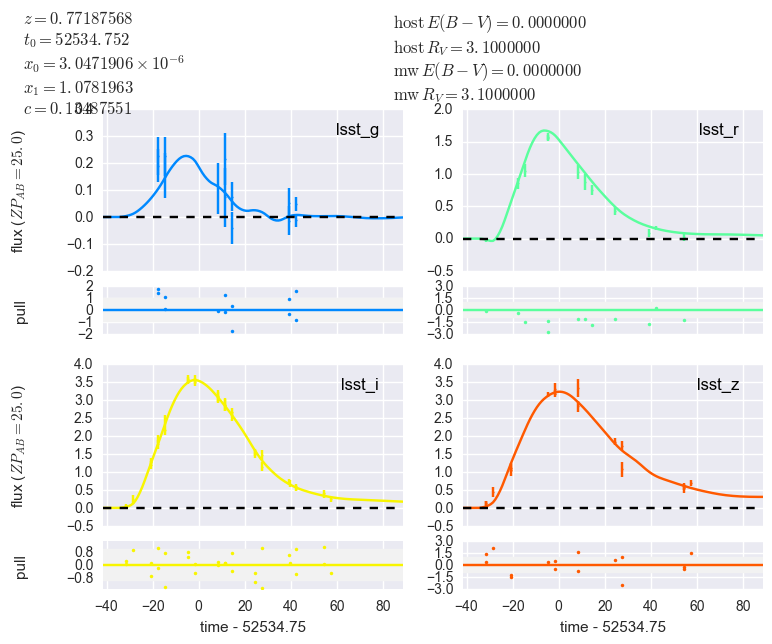

In [27]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar.sncosmoModel)

### What if we did not know z?

In [32]:
fitres_z = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c', 'z'], guess_z=True, 
                          bounds=dict(z=(0.65, 0.85)),
                          modelcov=True)

In [33]:
fitresChar_z = ans.ResChar.fromSNCosmoRes(fitres_z)
fitresChar_z.parameters

z              0.788165
t0         52534.978648
x0             0.000003
x1             1.086349
c              0.104184
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [34]:
fitresChar_z.mu_variance_linear()**0.5

          mB        x1         c
mB  0.000667  0.001873  0.000257
x1  0.001873  0.030879  0.001126
c   0.000257  0.001126  0.002503 [ 1.    0.14 -3.1 ]


0.15256957008918959

13.6186340533


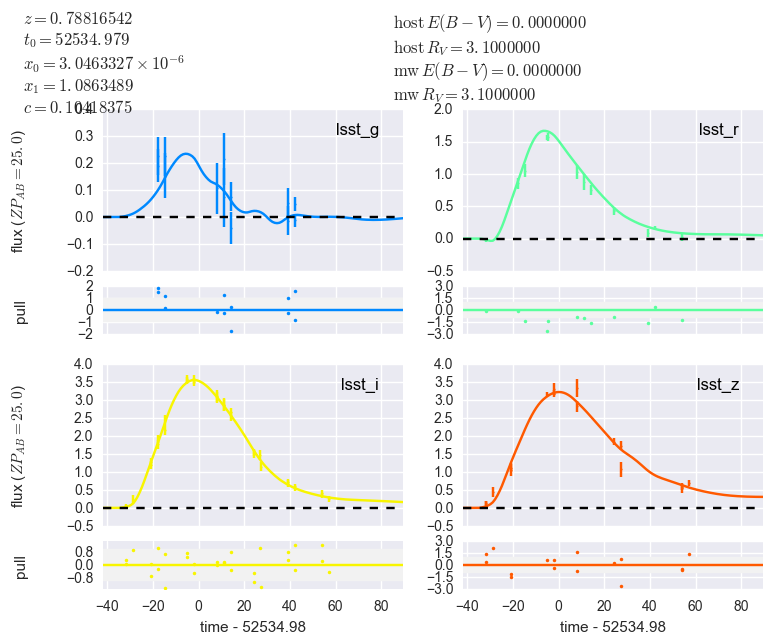

In [35]:
print computeMu(fitresChar_z)
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar_z.sncosmoModel)

### Now we repeat this in a different method
The maximum likelihood method above is not good if the likelihood are too far from the Gaussian. A method to sample posteriors is better. Such a method can be based on a MCMC run. We do that here by the following code

In [21]:
samples = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

These are samples of these parameters :

In [22]:
ans.ResChar.fromSNCosmoRes(samples).samples.head()

,t0,x0,x1,c
0,49576.210015,0.000078,-2.435445,-0.149629
1,49576.373573,0.000079,-2.425703,-0.165327
2,49576.137107,0.000076,-2.405436,-0.129147
3,49575.809954,0.000079,-2.460816,-0.159886
4,49576.018760,0.000077,-2.386437,-0.134721


In [25]:
import time

tstart = time.time()
samples_z_nomodelcov = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                                       bounds=dict(z=(0.1, 0.5)), modelcov=False)
tend = time.time()
print(tend-tstart)

584.010951996


In [26]:
tstart = time.time()
samples_z = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                           bounds=dict(z=(0.2, 0.6)), modelcov=True)
tend = time.time()
print(tend-tstart)

853.188168049


In [27]:
ans.ResChar.fromSNCosmoRes(samples_z).samples.head()

,z,t0,x0,x1,c
0,0.370704,49589.126525,0.002588,-14.652253,0.286617
1,0.370704,49589.126525,0.002588,-14.652253,0.286617
2,0.370704,49589.126525,0.002588,-14.652253,0.286617
3,0.370704,49589.126525,0.002588,-14.652253,0.286617
4,0.370704,49589.126525,0.002588,-14.652253,0.286617


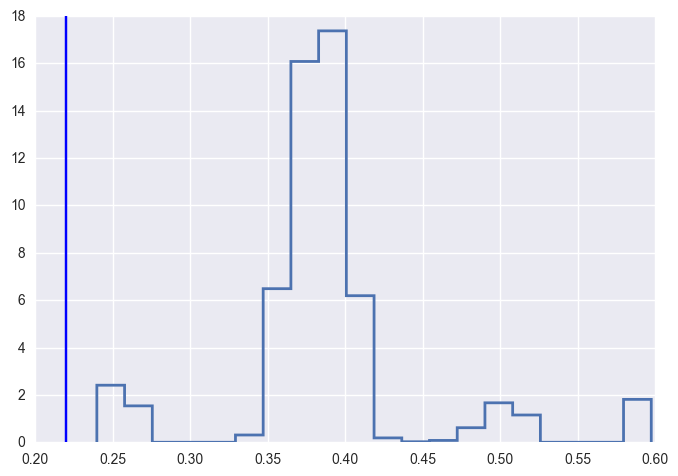

In [28]:
fig, ax = plt.subplots()
ans.ResChar.fromSNCosmoRes(samples_z).samples.z.hist(histtype='step', bins=20, lw=2., alpha=1., normed=1, ax=ax)
ax.axvline(0.22)